# Image Captioning Project

This project involved the use of a modified **pre-trained ResNet50 model** to map english words to the input image’s features to produce a caption through text generators (of GloVe word embedding).

**Concepts Used:** Image Processing, Word Embeddings, GAN modelling. 

*   Trained on 8kFlickr dataset. 
*   Coded using keras with tensorflow backend.
*   ResNet50 model is used to extract features from the images.
*   BLEU score as its evaluation metric.

Step 0: Importing the libaries required for the project

In [ ]:
# Importing the Required Libraries

import numpy as np
import matplotlib.pyplot as plt
from keras.models import Model, load_model
from keras.preprocessing import image
import time
import pickle
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import *
import pandas as pd
from nltk.translate.bleu_score import sentence_bleu
import re
import nltk

In [ ]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
# ! kaggle datasets download -d hsankesara/flickr-image-dataset
! kaggle datasets download -d adityajn105/flickr8k

mkdir: cannot create directory ‘/root/.kaggle’: File exists
 99% 1.03G/1.04G [00:08<00:00, 162MB/s]
100% 1.04G/1.04G [00:08<00:00, 131MB/s]


In [ ]:
! mkdir Dataset
! unzip /content/flickr8k.zip 
! rm /content/flickr8k.zip
! mv /content/Images /content/Dataset

Streaming output truncated to the last 5000 lines.
  inflating: Images/2844846111_8c1cbfc75d.jpg  
  inflating: Images/2844963839_ff09cdb81f.jpg  
  inflating: Images/2845246160_d0d1bbd6f0.jpg  
  inflating: Images/2845691057_d4ab89d889.jpg  
  inflating: Images/2845845721_d0bc113ff7.jpg  
  inflating: Images/2846037553_1a1de50709.jpg  
  inflating: Images/2846785268_904c5fcf9f.jpg  
  inflating: Images/2846843520_b0e6211478.jpg  
  inflating: Images/2847514745_9a35493023.jpg  
  inflating: Images/2847615962_c330bded6e.jpg  
  inflating: Images/2847859796_4d9cb0d31f.jpg  
  inflating: Images/2848266893_9693c66275.jpg  
  inflating: Images/2848571082_26454cb981.jpg  
  inflating: Images/2848895544_6d06210e9d.jpg  
  inflating: Images/2848977044_446a31d86e.jpg  
  inflating: Images/2849194983_2968c72832.jpg  
  inflating: Images/2850719435_221f15e951.jpg  
  inflating: Images/2851198725_37b6027625.jpg  
  inflating: Images/2851304910_b5721199bc.jpg  
  inflating: Images/2851931813_eaf8ed

### Data Preprocessing

In [ ]:
dataset = pd.read_csv('/content/captions.txt',delimiter=',',header=None)
dataset=dataset[1:]

In [ ]:
print(dataset.shape)

(40455, 2)


In [ ]:
dataset.head()

,0,1
1,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
2,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
3,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
4,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
5,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [ ]:
print(dataset[0][3])
print(dataset[1][3])

1000268201_693b08cb0e.jpg
A little girl climbing into a wooden playhouse .


## Text pre-processing
Using regular expressing to get lower case and has been joint with start and end sequence tag.

In [ ]:
# Libraries to be used for data cleaning
corpus = []
for i in range(1, dataset.shape[0]):
    cap = re.sub('[^a-zA-Z]', ' ', dataset[1][i])  #Removed all other characters except alphabets
    cap = cap.lower()                              #Converted to lower case
    cap = cap.split()                               
    cap=[word for word in cap if len(word)>1]      #Removed single letter words
    cap = ' '.join(cap)                            # Joined with spaces
    cap= '<startseq> '+cap+' <endseq>'
    corpus.append(cap)                             #list of captions

In [ ]:
for i in range(50): print(corpus[i:i+1])
print(len(corpus))

['<startseq> child in pink dress is climbing up set of stairs in an entry way <endseq>']
['<startseq> girl going into wooden building <endseq>']
['<startseq> little girl climbing into wooden playhouse <endseq>']
['<startseq> little girl climbing the stairs to her playhouse <endseq>']
['<startseq> little girl in pink dress going into wooden cabin <endseq>']
['<startseq> black dog and spotted dog are fighting <endseq>']
['<startseq> black dog and tri colored dog playing with each other on the road <endseq>']
['<startseq> black dog and white dog with brown spots are staring at each other in the street <endseq>']
['<startseq> two dogs of different breeds looking at each other on the road <endseq>']
['<startseq> two dogs on pavement moving toward each other <endseq>']
['<startseq> little girl covered in paint sits in front of painted rainbow with her hands in bowl <endseq>']
['<startseq> little girl is sitting in front of large painted rainbow <endseq>']
['<startseq> small girl in the grass

In [ ]:
i=1
while i < dataset.shape[0]:
  dataset[0][i]=dataset[0][i].split('.')[0]        #Removed characters after '.'
  i=i+1

In [ ]:
print(dataset.head)

<bound method NDFrame.head of                               0  \
1         1000268201_693b08cb0e   
2         1000268201_693b08cb0e   
3         1000268201_693b08cb0e   
4         1000268201_693b08cb0e   
5         1000268201_693b08cb0e   
...                         ...   
40451      997722733_0cb5439472   
40452      997722733_0cb5439472   
40453      997722733_0cb5439472   
40454      997722733_0cb5439472   
40455  997722733_0cb5439472.jpg   

                                                       1  
1      A child in a pink dress is climbing up a set o...  
2                  A girl going into a wooden building .  
3       A little girl climbing into a wooden playhouse .  
4      A little girl climbing the stairs to her playh...  
5      A little girl in a pink dress going into a woo...  
...                                                  ...  
40451           A man in a pink shirt climbs a rock face  
40452           A man is rock climbing high in the air .  
40453  A person in

In [ ]:
type(dataset)

pandas.core.frame.DataFrame

In [ ]:
# Joins the Images to its captions using a dictionary 

from collections import defaultdict
new_dict= defaultdict(lambda : [])          #Created a dictionary with image ids as key and captions as value
i=1
while i <len(corpus):
  # print(dataset[0][i])
  new_dict[dataset[0][i]].append(corpus[i-1])
  i=i+1                                                     

In [ ]:
print(len(new_dict))

8091


In [ ]:
all_vocab = []              #A list of all the words in the captions

for key in new_dict.keys():
    [ all_vocab.append(i) for des in new_dict[key] for i in des.split()]

In [ ]:
print("total words appearing : " , len(all_vocab))

total words appearing :  454697


Creating a word counter for the corpus

In [ ]:
from collections import Counter

counter = Counter(all_vocab)

In [ ]:
dic_ = dict(counter)

In [ ]:
sorted_dic = sorted(dic_.items(), key = lambda x: x[1], reverse=True)   #List with words and their corresponding frequency

In [ ]:
print(len(sorted_dic))

8426


In [ ]:

# for i in range(len(sorted_dic)):print(sorted_dic[i]) 

In [ ]:
# we decide upon a threshold value which helps in selecting the words that occur more than others in the corpus
# Here we choose a threshold of 10, so that words that occur more than 10 times in the entire corpus are chosen

threshold_value = 10

d = [(x) for x in sorted_dic if x[1]>threshold_value]

In [ ]:
len(d)

1847

In [ ]:
all_vocab = [x[0] for x in d]                       #Updating all_vocab

In [ ]:
len(all_vocab)

1847

In [ ]:
f = open('new_dict.txt', 'w')
f.write(str(new_dict))
f.close()

### Splitting image captions dataset into training and testing dataset and appending it all in 2 lists 

In [ ]:
image_ids=[]
j=1
for i in range(0,len(dataset)//5 ):
    image_ids.append(dataset[0][j])
    j=j+5
    

In [ ]:
# print(image_ids)

In [ ]:
new_dict[image_ids[0]]

['<startseq> child in pink dress is climbing up set of stairs in an entry way <endseq>',
 '<startseq> girl going into wooden building <endseq>',
 '<startseq> little girl climbing into wooden playhouse <endseq>',
 '<startseq> little girl climbing the stairs to her playhouse <endseq>',
 '<startseq> little girl in pink dress going into wooden cabin <endseq>']

In [ ]:
split_train_to_test_ratio=0.8
train_end=int(split_train_to_test_ratio*len(image_ids))

train=image_ids[0:train_end]
test=image_ids[train_end:]

In [ ]:
# train

In [ ]:
train_descriptions = {}               #dictionary with keys as image ids and values as corresponding captions
for t in train:
    train_descriptions[t] = []
    for cap in new_dict[t]:
        train_descriptions[t].append(cap)

In [ ]:
test_descriptions = {}             #dictionary with keys as image ids and values as corresponding captions
for t in test:
    test_descriptions[t] = []
    for cap in new_dict[t]:
        test_descriptions[t].append(cap)

In [ ]:
# train_descriptions

In [ ]:
# test_descriptions

In [ ]:
# i=0
# for keys,values in train_descriptions.items():
#  i=i+1
 
#  print(keys)
#  print(values)
#  if i>50:break

### Importing and Loading the model

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from keras.models import load_model

In [ ]:
# model = load_model('../input/keras-pretrained-models/resnet50_weights_tf_dim_ordering_tf_kernels.h5')

In [ ]:
model = ResNet50(weights = 'imagenet', input_shape = (224,224,3))

102981632/102967424 [==============================] - 1s 0us/step


In [ ]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
model_new = Model(inputs = model.input, outputs =  model.layers[-2].output)

#### Image Preprocessing
We take the train & test image datasets and preprocess them.

In [ ]:
# Function to preprocess images

def preprocess_image(img):
    img = image.load_img(img, target_size=(224,224))
    img = image.img_to_array(img)
    img = preprocess_input(img)
    img = np.expand_dims(img, axis = 0)

    return img


In [ ]:
# Function for obtaining feature vectors (encodings) from images

def encode_image(img):
    img = preprocess_image(img)
    fea_vec = model_new.predict(img)
    fea_vec = fea_vec.reshape(fea_vec.shape[1], )
    return fea_vec

In [ ]:
images='/content/Dataset/Images/'

In [ ]:
 # Obtaining Feature vector from training images
 
start = time.time()

encoding_train = {}                #Dictionary with keys as image ids and values as encoding corresponding to the images                        

for ix, img in enumerate(train):
    
    img = images+train[ix]+".jpg"
    
    p = encode_image(img)
    
    encoding_train[ img[len(images):] ] = p
    
    
    if ix%100 == 0:
        print("Encoding image :" + str(ix))
    
print("Time taken in sec - " + str(time.time() - start))

Encoding image :0
Encoding image :100
Encoding image :200
Encoding image :300
Encoding image :400
Encoding image :500
Encoding image :600
Encoding image :700
Encoding image :800
Encoding image :900
Encoding image :1000
Encoding image :1100
Encoding image :1200
Encoding image :1300
Encoding image :1400
Encoding image :1500
Encoding image :1600
Encoding image :1700
Encoding image :1800
Encoding image :1900
Encoding image :2000
Encoding image :2100
Encoding image :2200
Encoding image :2300
Encoding image :2400
Encoding image :2500
Encoding image :2600
Encoding image :2700
Encoding image :2800
Encoding image :2900
Encoding image :3000
Encoding image :3100
Encoding image :3200
Encoding image :3300
Encoding image :3400
Encoding image :3500
Encoding image :3600
Encoding image :3700
Encoding image :3800
Encoding image :3900
Encoding image :4000
Encoding image :4100
Encoding image :4200
Encoding image :4300
Encoding image :4400
Encoding image :4500
Encoding image :4600
Encoding image :4700
Enco

In [ ]:
len(encoding_train)

In [ ]:
encoding_train[train[0]+".jpg"]

In [ ]:
print("Time taken in sec - " + str(time.time() - start))

In [ ]:
 # Obtaining Feature vector from test images

start = time.time()

encoding_test = {}

for ix, img in enumerate(test):
    
    img = images+test[ix]+".jpg"
    
    p = encode_image(img)
    
    encoding_test[ img[len(images):] ] = p
    
    
    if ix%100 == 0:
        print("Encoding image :" + str(ix))
    
print("Time taken in sec - " + str(time.time() - start))

In [ ]:
# saving features to disk

with open("./encoded_train_images.pkl", 'wb') as f:
    pickle.dump(encoding_train, f )

In [ ]:
with open("./encoded_test_images.pkl", 'wb') as f:
    pickle.dump(encoding_test, f )

In [ ]:
with open("./encoded_train_images.pkl", 'rb') as f:
    encoding_train = pickle.load(f)

In [ ]:
with open("./encoded_test_images.pkl", 'rb') as f:
    encoding_test = pickle.load(f)

**Captions**

In [ ]:
word_to_idx = {}
idx_to_word = {}

ix = 1

for e in all_vocab:
    #print(ix,e)
    word_to_idx[e] = ix
    idx_to_word[ix] = e
    ix +=1

In [ ]:
i=0
for keys,values in word_to_idx.items():
 i=i+1
 
 print(keys,values)
 
 if i>50:break

<startseq> 1
<endseq> 2
in 3
the 4
on 5
is 6
and 7
dog 8
with 9
man 10
of 11
two 12
white 13
black 14
boy 15
are 16
woman 17
girl 18
to 19
wearing 20
at 21
people 22
water 23
red 24
young 25
brown 26
an 27
his 28
blue 29
dogs 30
running 31
through 32
playing 33
while 34
shirt 35
down 36
standing 37
ball 38
little 39
grass 40
snow 41
child 42
person 43
jumping 44
over 45
three 46
front 47
sitting 48
holding 49
up 50
field 51


In [ ]:
for i in range(51):print(all_vocab[i])

<startseq>
<endseq>
in
the
on
is
and
dog
with
man
of
two
white
black
boy
are
woman
girl
to
wearing
at
people
water
red
young
brown
an
his
blue
dogs
running
through
playing
while
shirt
down
standing
ball
little
grass
snow
child
person
jumping
over
three
front
sitting
holding
up
field


In [ ]:
len(all_vocab)

1847

In [ ]:
vocab_size = len(idx_to_word) + 1
print(vocab_size)


1848


In [ ]:
all_caption_len = []

for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        all_caption_len.append(len(cap.split()))

In [ ]:
print(len(all_caption_len))
print(all_caption_len[:50])

32360
[16, 7, 8, 10, 11, 9, 15, 18, 14, 10, 18, 12, 19, 13, 11, 12, 14, 16, 11, 13, 10, 9, 11, 11, 14, 7, 8, 12, 12, 11, 15, 11, 9, 15, 11, 14, 14, 14, 14, 16, 11, 18, 8, 17, 21, 7, 9, 8, 14, 9]


In [ ]:
max_len = max(all_caption_len)
print(max_len) 

35


### Generator Function
The Data Generator maps the Image encodings with the training captions for the training of the model

In [ ]:
def data_generator(train_descriptions, encoding_train, word_to_idx, max_len,  num_photos_per_batch ):
    X1, X2, y = [], [], []
    
    n=0
    cnt = 0
    all_items = list(train_descriptions.keys())
    
    while True:
      n+=1
      # print(cnt)
      key = all_items[cnt]
      desc_list = train_descriptions[key]              
      cnt+=1
      cnt= (cnt%len(all_items))
        
      photo = encoding_train[key+".jpg"]          #feature vector
            #print(photo.shape)
      for desc in desc_list:                       #desc : iterates through the 5 captions
        seq = [word_to_idx[word] for word in desc.split() if word in word_to_idx]                
                
        for i in range(1, len(seq)): 
            in_seq = seq[0:i]
            out_seq = seq[i]
            
            in_seq = pad_sequences( [in_seq], maxlen=max_len, value= 0, padding='post')[0]
        
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            
            X1.append(photo)
            X2.append(in_seq)
            y.append(out_seq)

      if n == num_photos_per_batch:
          yield [np.array(X1), np.array(X2)] , np.array(y)
          X1, X2, y = [], [], []
          n = 0         

In [ ]:
# key="1000268201_693b08cb0e"
# print(key)
# print(encoding_train[key+".jpg"])

In [ ]:
# encoding_train

In [ ]:
# for i in data_generator(train_descriptions, encoding_train, word_to_idx, max_len, 3):
#     X, y = i
#     print(X[0].shape) 
#     print(X[1].shape)
#     print(y.shape)
#     break

###  Word Embedding
Of GloVe embeddings

In [ ]:
embeddings = {}

with open("../input/glove6b200d/glove.6B.200d.txt", 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coeffs = np.array(values[1:], dtype="float32")
        
        embeddings[word] = coeffs


In [ ]:
i=0
for keys,values in embeddings.items():
 i=i+1
 
 print(keys,values)
 
 if i>10:break

the [-7.1549e-02  9.3459e-02  2.3738e-02 -9.0339e-02  5.6123e-02  3.2547e-01
 -3.9796e-01 -9.2139e-02  6.1181e-02 -1.8950e-01  1.3061e-01  1.4349e-01
  1.1479e-02  3.8158e-01  5.4030e-01 -1.4088e-01  2.4315e-01  2.3036e-01
 -5.5339e-01  4.8154e-02  4.5662e-01  3.2338e+00  2.0199e-02  4.9019e-02
 -1.4132e-02  7.6017e-02 -1.1527e-01  2.0060e-01 -7.7657e-02  2.4328e-01
  1.6368e-01 -3.4118e-01 -6.6070e-02  1.0152e-01  3.8232e-02 -1.7668e-01
 -8.8153e-01 -3.3895e-01 -3.5481e-02 -5.5095e-01 -1.6899e-02 -4.3982e-01
  3.9004e-02  4.0447e-01 -2.5880e-01  6.4594e-01  2.6641e-01  2.8009e-01
 -2.4625e-02  6.3302e-01 -3.1700e-01  1.0271e-01  3.0886e-01  9.7792e-02
 -3.8227e-01  8.6552e-02  4.7075e-02  2.3511e-01 -3.2127e-01 -2.8538e-01
  1.6670e-01 -4.9707e-03 -6.2714e-01 -2.4904e-01  2.9713e-01  1.4379e-01
 -1.2325e-01 -5.8178e-02 -1.0290e-03 -8.2126e-02  3.6935e-01 -5.8442e-04
  3.4286e-01  2.8426e-01 -6.8599e-02  6.5747e-01 -2.9087e-02  1.6184e-01
  7.3672e-02 -3.0343e-01  9.5733e-02 -5.2860e-0

In [ ]:
print(len(embeddings))

400000


In [ ]:
def getOutputEmbeddings():

    emb_dim = 200
    embedding_matrix_output = np.zeros((vocab_size, emb_dim ))
    
    for word, idx in word_to_idx.items():
        
        emb_vec = embeddings.get(word)
        
        if emb_vec is not None:
            embedding_matrix_output[idx] = emb_vec
            
    return embedding_matrix_output

In [ ]:
embedding_output = getOutputEmbeddings()

In [ ]:
embedding_output.shape

(1848, 200)

In [ ]:
print(embedding_output[5:7])

[[-0.39374     0.55684    -0.35848001 -0.67074001  0.073665    0.12643
  -0.013077   -0.25279999 -0.04863     0.087937   -0.20308     0.43673
   0.18453    -0.027372    0.18987     0.23822001 -0.092781    0.31736001
   0.15368     0.14471     0.37138     3.15409994  0.13773     0.0037497
   0.14195     0.40222001 -0.56691003  0.17663001 -0.37059999  0.19401
   0.074044   -0.19639     0.093499    0.78948998  0.10651    -0.54262
  -0.82392001 -0.59018999 -0.0074686   0.048896    0.26594999 -0.071857
   0.28968     0.46733001  0.17434999  0.65547001  0.069246   -0.78889
   0.20286     0.44911    -0.54470998  0.10789     0.040975    0.60115999
  -0.14781    -0.21917     0.16495     0.40391001  0.33915001  0.36809999
   0.034313   -0.19927999 -0.40278    -0.15649     0.010548   -0.27677
   0.066898   -0.16745999  0.1288     -0.11875     0.13574    -0.13967
  -0.1601      0.20059     0.042929    0.34299999  0.027023   -0.26837999
   0.096476    0.05495    -0.20767    -0.52867001 -0.32010999 

### Model Architecture
Development and stacking of the model's layers

In [ ]:
input_img_fea = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_fea)
inp_img2 = Dense(256, activation='relu')(inp_img1)

In [ ]:
print(inp_img2.shape)

(None, 256)


In [ ]:
input_cap = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim= vocab_size, output_dim=200, mask_zero=True)(input_cap)

inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [ ]:
print(inp_cap3.shape)

(None, 256)


In [ ]:
decoder1 = add([inp_img2, inp_cap3])
print(decoder1.shape)
decoder2 = Dense(256, activation='relu')(decoder1)
output = Dense(vocab_size, activation='softmax')(decoder2)


model = Model(inputs = [input_img_fea, input_cap]  , outputs =  output )

(None, 256)


In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 35)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 35, 200)      369600      input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [ ]:
# model.layers[2].set_weights([embedding_output])
# model.layers[2].trainable = False

In [ ]:
# model.compile(loss="categorical_crossentropy", optimizer='adam') 

### Model Training

In [ ]:
# epochs = 30
# number_photos_per_batch = 3
# steps = len(train_descriptions)//number_photos_per_batch

# mytraingen = data_generator(train_descriptions, encoding_train, word_to_idx, max_len, number_photos_per_batch)

# model.fit(mytraingen,steps_per_epoch=steps,epochs = epochs)
# model.save(filepath="./best_model1.h5")

In [ ]:
# model.save_weights("./weights1.h5") 

### Predictor Function
This function takes an image and predicts the corresponding caption for it by pasiing it into the model

In [ ]:
def predict(photo_enc,model):
    in_text = "<startseq>"
    
    for i in range(max_len):
        sequence = [word_to_idx[word] for word in in_text.split() if word in word_to_idx]
        #print(sequence)
        sequence = pad_sequences([sequence], maxlen=max_len, padding='post')
        
        y_pred = model.predict([photo_enc, sequence])
        y_pred = np.argmax(y_pred)
        word = idx_to_word[y_pred]
        
        in_text += " "+word
        
        if word == '<endseq>':
            break
        
        
    final_caption = in_text.split()
    final_caption = final_caption[1:-1]
    final_caption = " ".join(final_caption)
    return final_caption

In [ ]:
model=load_model("../input/image-caption-trained-model/best_model1.h5")

In [ ]:
# len(encoding_test)

In [ ]:
# scores=[]
# for rn in range(5):
#     img_id = list(encoding_test.keys())[rn]
#     photo_enc = encoding_test[img_id].reshape((1,2048))
#     sh_img_id=img_id[:-4]
#     reference=new_dict[sh_img_id]
#     references=[]
#     print(img_id)

#     for ref in reference:
#         ref=ref[11:-9]
#         ref=ref.split(' ')
#         references.append(ref)
#     pred = predict(photo_enc,model)
#     translation=pred.split(' ')
#     score1 = sentence_bleu(references, translation)
#     scores.append(score1)
#     print("BLEU Score for image id : "+img_id+"is : "+str(score1))
#     print('1 '+ pred)
#     path = images + img_id
#     img = plt.imread(path)
#     plt.imshow(img)
#     plt.show()

   

In [ ]:
# scores=[]
# for rn in range(1619):
#     img_id = list(encoding_test.keys())[rn]
#     photo_enc = encoding_test[img_id].reshape((1,2048))
#     sh_img_id=img_id[:-4]
#     reference=new_dict[sh_img_id]
#     references=[]

#     for ref in reference:
#         ref=ref[11:-9]
#         ref=ref.split(' ')
#         references.append(ref)
#     pred = predict(photo_enc,model)
#     translation=pred.split(' ')
#     score1 = sentence_bleu(references, translation)
#     scores.append(score1)

In [ ]:
# scores

In [ ]:
# from statistics import mean

# print("Max : "+str(max(scores)))
# print("Min : "+str(min(scores)))
# print("Average : "+str(mean(scores)))


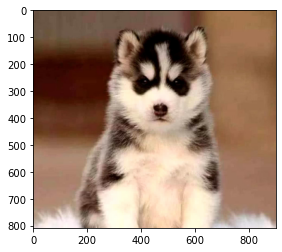

In [ ]:
img1 = plt.imread('../input/xinxiatest/content.jpg')
plt.imshow(img1)
plt.show()

In [ ]:
photo_enc = encode_image('../input/xinxiatest/content.jpg').reshape((1,2048))
predict(photo_enc,model)

'white and black dog is running on the green dirt'

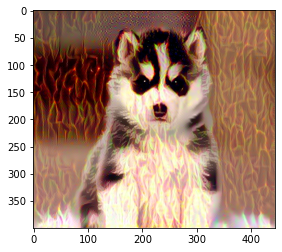

In [ ]:
img2 = plt.imread('../input/xinxiatest/img.png')
plt.imshow(img2)
plt.show()

In [ ]:
photo_enc = encode_image('../input/xinxiatest/img.png').reshape((1,2048))
predict(photo_enc,model)

'dog is running on the carpet'